<div style="width: 30%; float: right; margin: 10px; margin-right: 5%;">
    <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/d3/FHNW_Logo.svg/2560px-FHNW_Logo.svg.png" width="500" style="float: left; filter: invert(50%);"/>
</div>

<h1 style="text-align: left; margin-top: 10px; float: left; width: 60%;">
    SAN Projekt:<br> Schweizer Offshore Firmen
</h1>

<p style="clear: both; text-align: left;">
    Bearbeitet durch Florin Barbisch, Gabriel Torres Gamez und Tobias Buess im FS 2024.
</p>

Wir führen eine Voranalyse für das Bundesamt für Statistik durch, um die kürzlich aufgetretenen Leaks aus den Offshore Papers zu untersuchen. 

Diese Analyse zielt darauf ab, Umfang und Natur der Verbindungen in Schweizer Offshore-Strukturen zu ermitteln. Wir verwenden dafür Daten aus der [Offshore Leaks Database](https://offshoreleaks.icij.org/), um mögliche Muster, wichtige Personen aufzudecken, die für die Steuerbehörden oder Regulierungsorgane von Interesse sein könnten. 

Unsere Arbeit umfasst eine detaillierte Prüfung der betroffenen Entitäten. Dies wird es dem Bundesamt für Statistik ermöglichen, fundierte Entscheidungen zur weiteren Untersuchung und möglichen Massnahmen zu treffen.

## Imports und Einstellungen

In [1]:
# Python internal modules
import os

# Project modules
import utils

# External modules
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt

BACKEND = None  # use default
if "cugraph" in nx.utils.backends.backends.keys():
    import nx_cugraph as nxcg

    BACKEND = "cugraph"

print("Python Environment:")
print(f" | Python version: {os.sys.version}")
print(f" | Numpy version: {np.__version__}")
print(f" | Pandas version: {pd.__version__}")
print(f" | Matplotlib version: {matplotlib.__version__}")
print(f" | NetworkX version: {nx.__version__}")
print(f" | NetworkX backend: {BACKEND}")
print(
    f" | CuGraph version: {nxcg.__version__}"
    if BACKEND == "cugraph"
    else " | CuGraph not installed, for better performance install it like this:\n\tpip install cugraph-cu12 --extra-index-url=https://pypi.ngc.nvidia.com"
)
print()
print("Ressources:")
print(f" | CPU: {os.cpu_count()} cores")

PAPERS = "Pandora Papers"
GRAPH_PATH = f"./data/{PAPERS.lower().replace(' ', '_')}_graph.gexf"

plt.rcParams["figure.figsize"] = [10, 3]
plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.size"] = 6

color_map = {
    "Entity": "#ff8080",
    "Officer": "#B0C4DE",
    "Intermediary": "tab:green",
    "Address": "#FFFF00",
    "Other": "tab:gray",
}

Python Environment:
 | Python version: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
 | Numpy version: 1.26.4
 | Pandas version: 2.2.1
 | Matplotlib version: 3.8.4
 | NetworkX version: 3.3
 | NetworkX backend: cugraph
 | CuGraph version: 24.04.00

Ressources:
 | CPU: 24 cores


## Daten laden

In [2]:
# Graph mit allen Nodes/Edges von den gewählten Papers laden
G = utils.get_graph(GRAPH_PATH, PAPERS)

# Subgraph mit allen Nodes/Edges von Connected Components welche mindestens 1 Schweizer Adresse beinhalten
G = utils.filter_graph_by_country_name(G, "Switzerland", verbose=True)

Info pre filtering:
Number of edges:  145874
Number of nodes:  108053
Number of weakly connected components:  2643

Filtering the graph after the country "Switzerland"

Info post filtering:
Number of edges:  127482
Number of nodes:  91864
Number of weakly connected components:  53


## Welche Schweizer Officers haben die meisten Offshore Firmen? 

In [3]:
# get swiss officers
swiss_officers = utils.filter_nodes(G, query="countries == 'Switzerland' and node_type == 'Officer'")
all_entities = utils.filter_nodes(G, query="node_type == 'Entity'")

swiss_officers_entities_subgraph_ = G.subgraph(set(swiss_officers) | set(all_entities))
filtered_edges_u_v_k = [(u, v, k) for u, v, k in swiss_officers_entities_subgraph_.edges(keys=True) if u in swiss_officers and v in all_entities]
swiss_officers_entities_subgraph = G.edge_subgraph(filtered_edges_u_v_k)

degree = dict(swiss_officers_entities_subgraph.out_degree(swiss_officers))
degree = dict(sorted(degree.items(), key=lambda item: item[1], reverse=True))

In [4]:
# Modify the edge label plotting to concatenate labels into a single string
def plot_ego_with_labels(G, subgraph, node, color_map, plot_subgraph=True, ego_radius=1):
    plot_graph = (subgraph if plot_subgraph else G).copy()
    ego = nx.ego_graph(plot_graph, node, radius=ego_radius, undirected=True)
    pos = nx.circular_layout(ego)
    colors = [color_map[G.nodes[n]["node_type"]] for n in ego.nodes]
    labels = {n: (G.nodes[n]["name"] if G.nodes[n]["node_type"] != "Address" else G.nodes[n]["address"].split(',')[0]) for n in ego.nodes}

    # Prepare edge labels by concatenating them into a single string per edge
    edge_labels = {}
    for u, v, d in ego.edges(data=True):
        key = (u, v)
        if key not in edge_labels:
            edge_labels[key] = []
        edge_labels[key].append(d['link'])

    combined_edge_labels = {k: "\n".join(v) for k, v in edge_labels.items()}

    # Draw nodes and labels
    nx.draw(
        ego,
        pos,
        with_labels=True,
        node_color=colors,
        labels=labels,
        font_size=plt.rcParams["font.size"],
        edge_color="#D3D3D3",
    )
    nx.draw_networkx_edge_labels(ego, pos, edge_labels=combined_edge_labels, font_color="red", font_size=plt.rcParams["font.size"] - 1)

    plt.title(f"Ego graph of {labels[node]}: {node}, Entity Out-Degrees: {deg}")
    plt.suptitle("Entity = red, Officer = blue, Intermediary = green, Address = yellow, Other = gray", y=0.01, fontsize=plt.rcParams["font.size"], color="gray")
    plt.show()

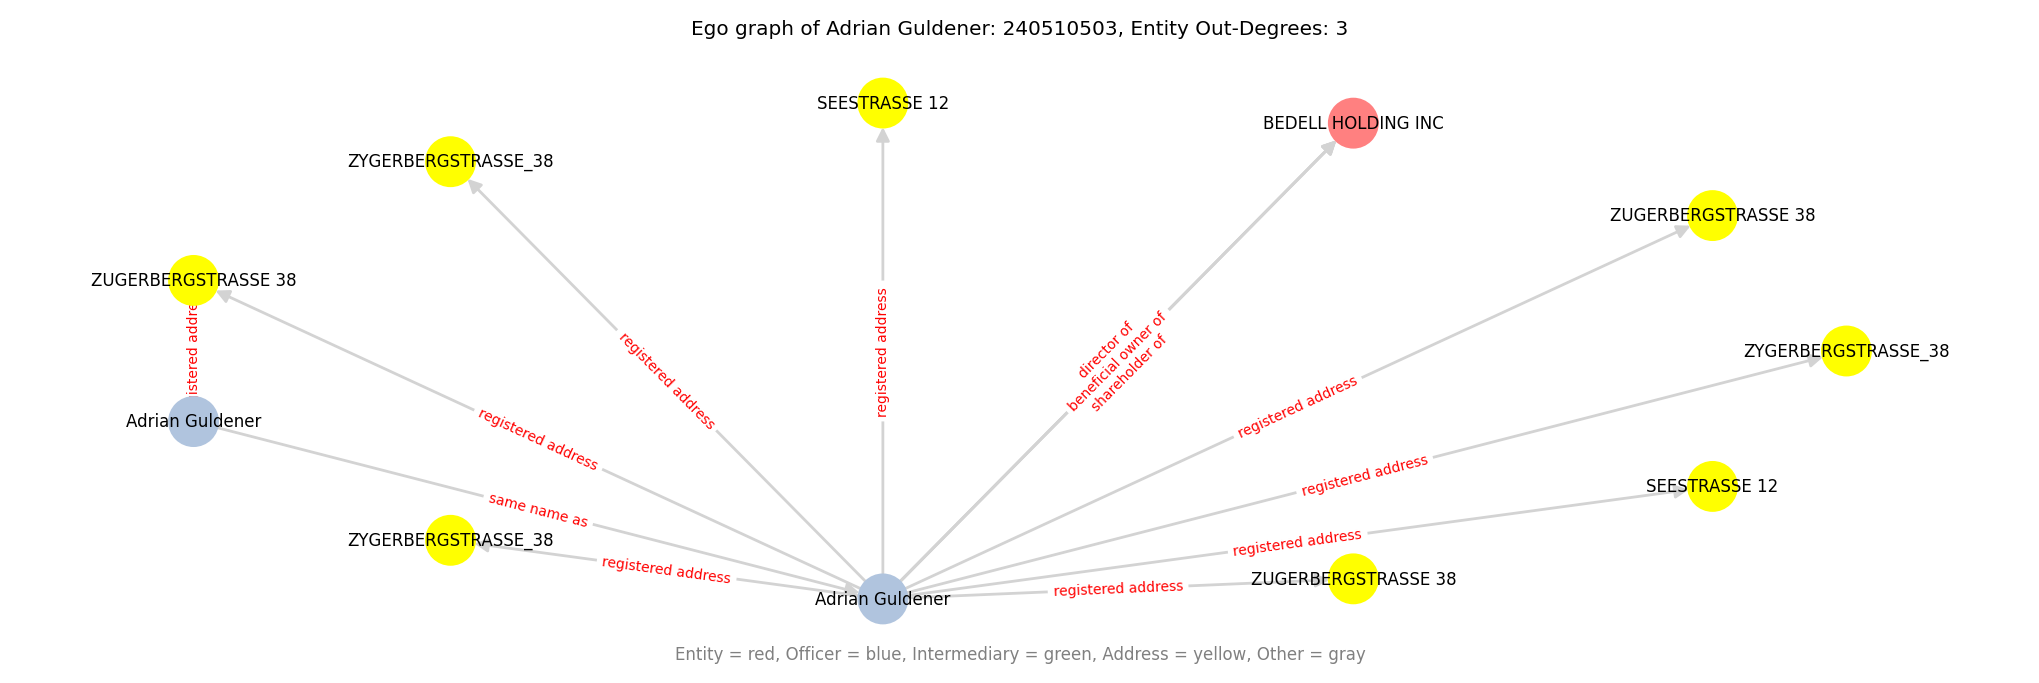

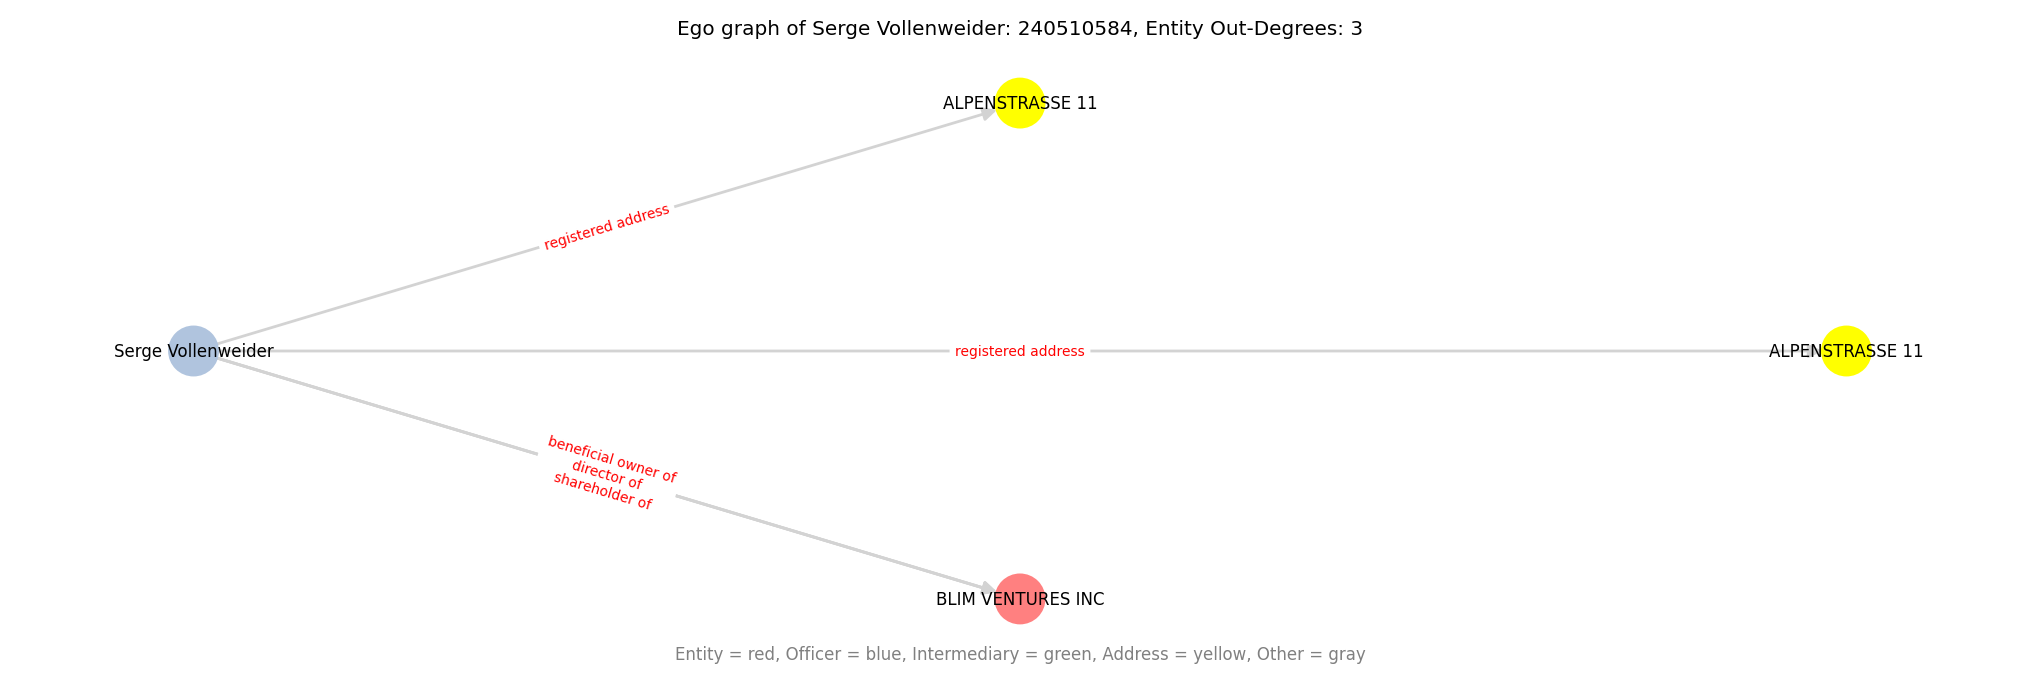

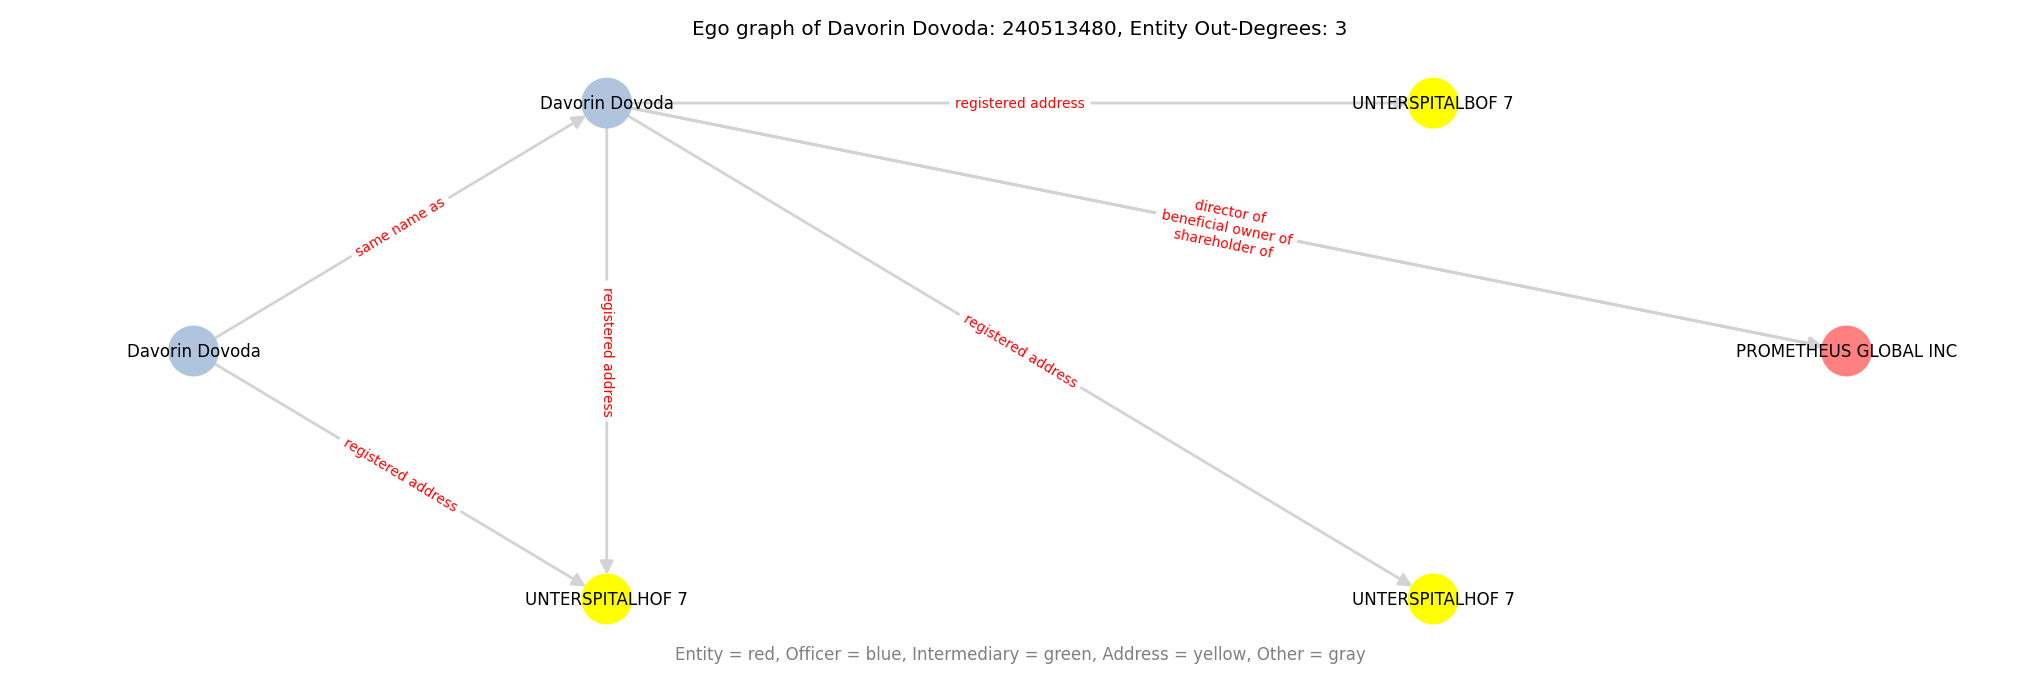

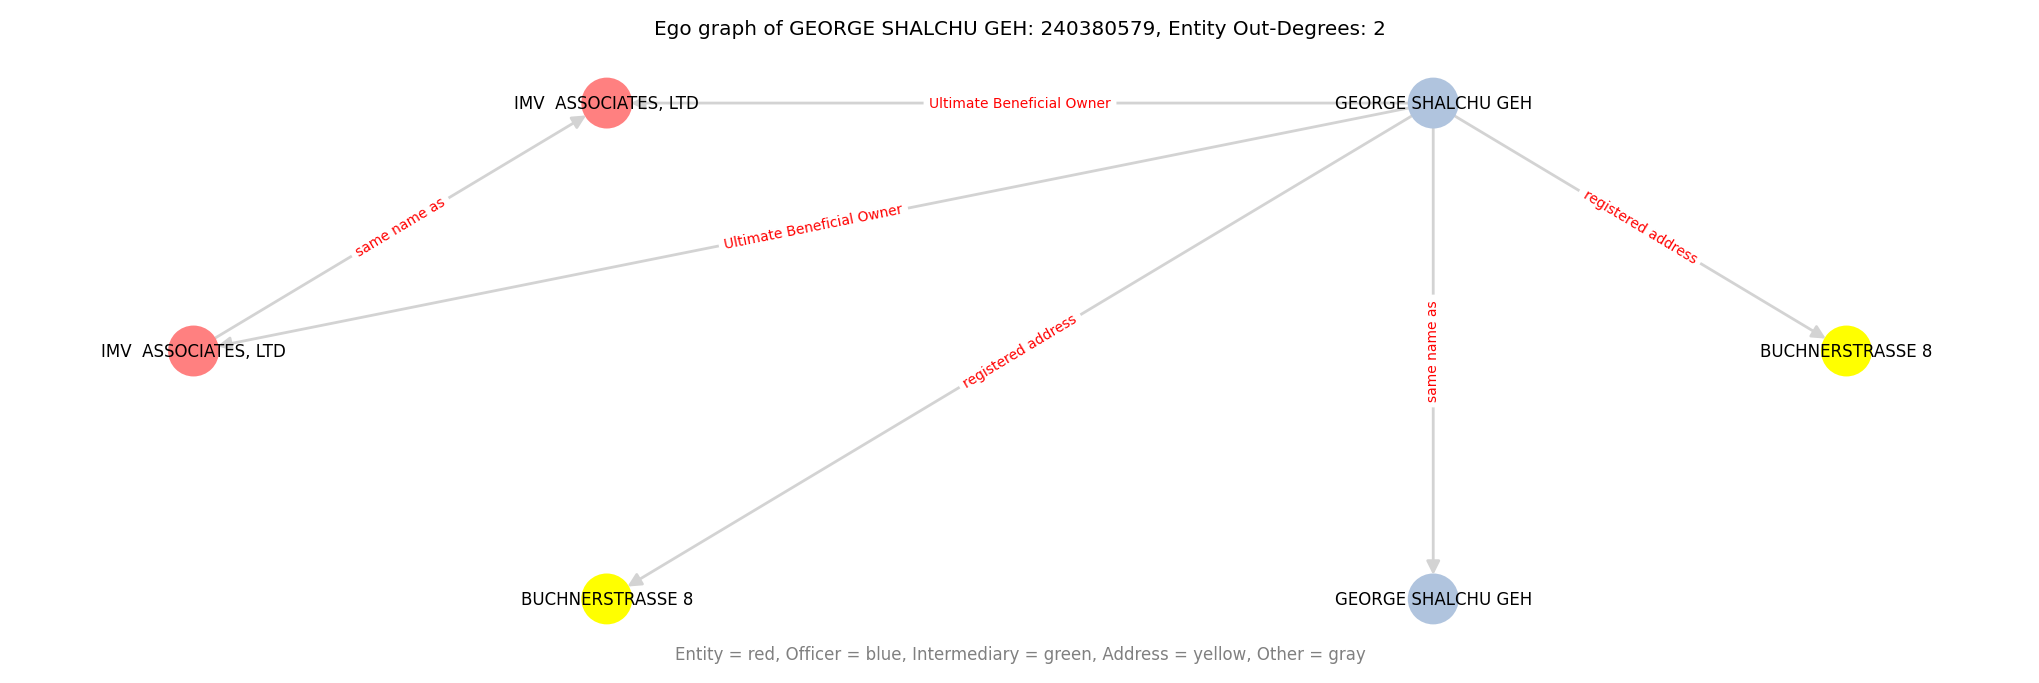

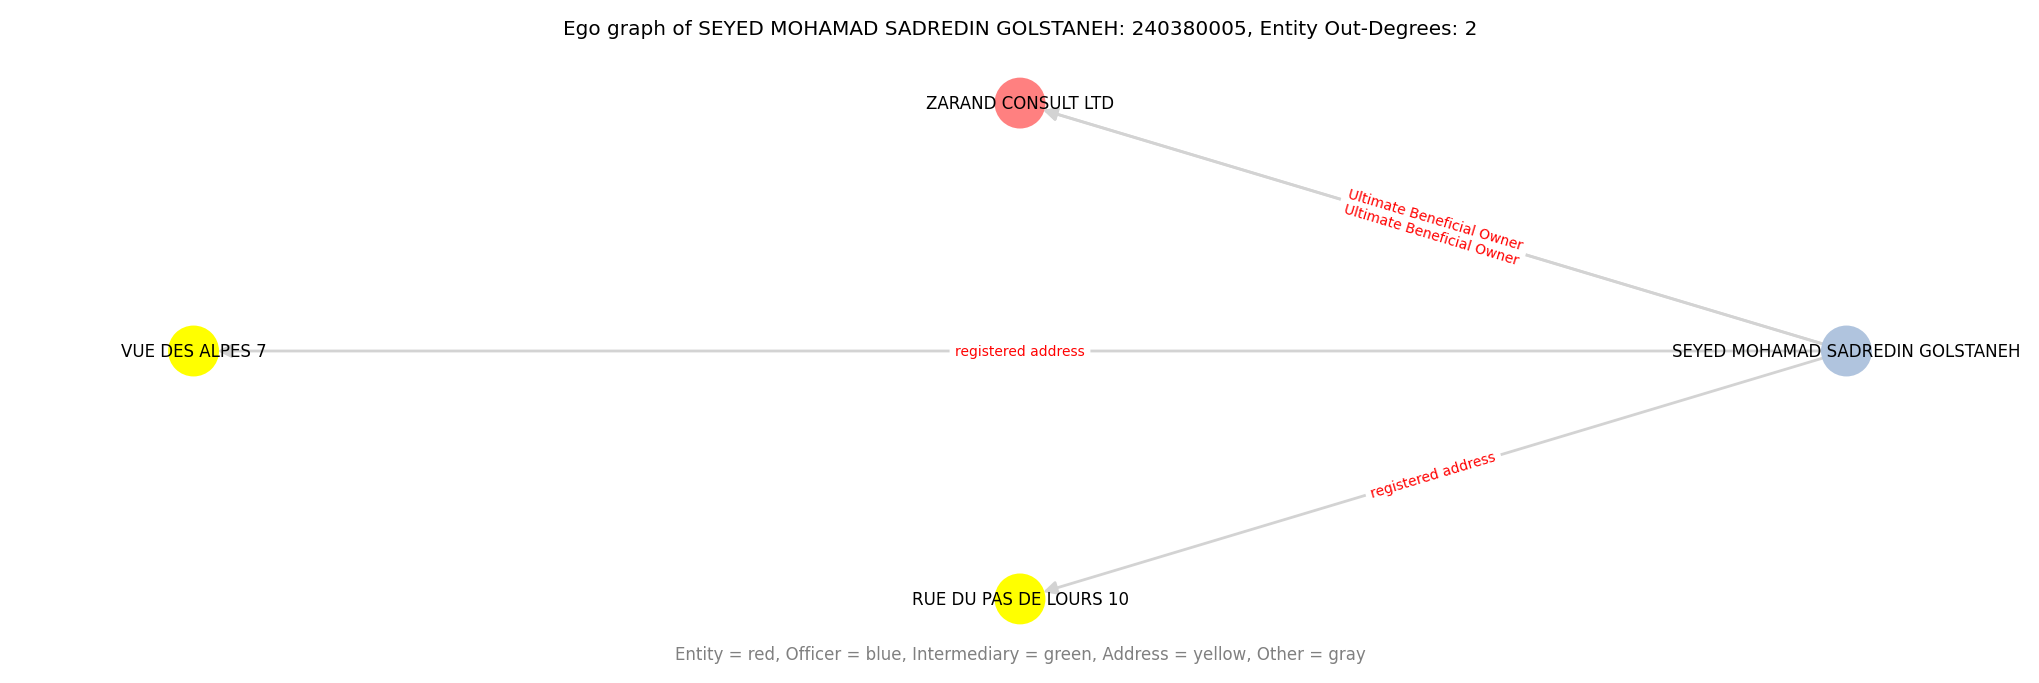

In [5]:
# Use the modified plotting function
for node, deg in list(degree.items())[:5]:
    plot_ego_with_labels(
        G, swiss_officers_entities_subgraph, node, color_map, plot_subgraph=False
    )

Es gibt nur wenige Entity Out-Degrees für alle Schweizer Officer Nodes. Jedoch existieren anscheinend mehrere Nodes im Datensatz gleich zu sein (z.B. mehrere Adrian Guldener). Als nächstes erweitern wir den ego_radius der Visualisierung.

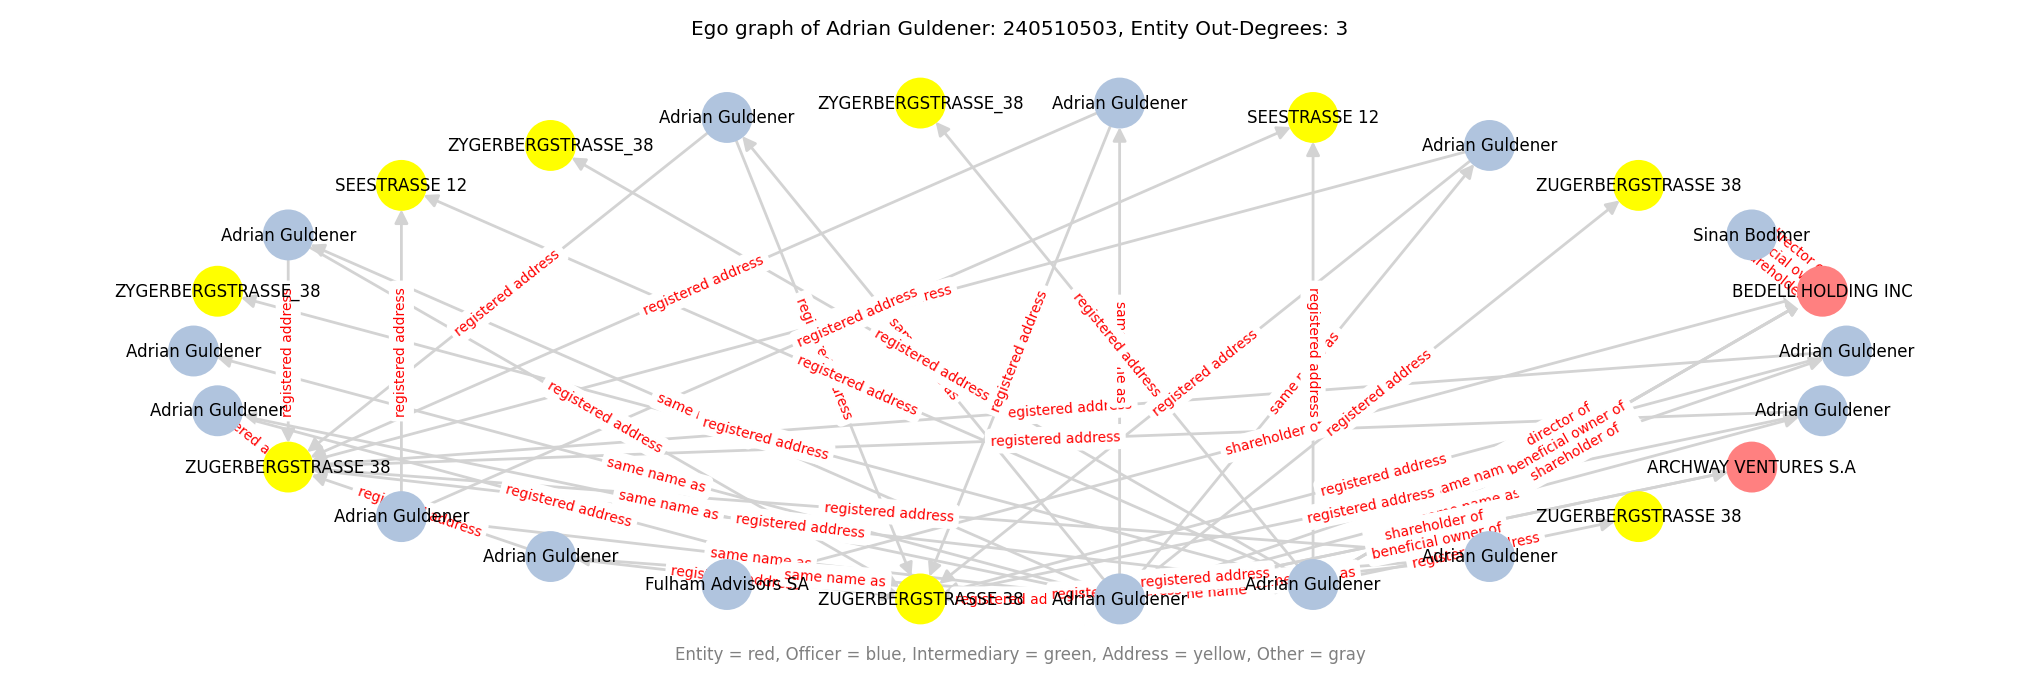

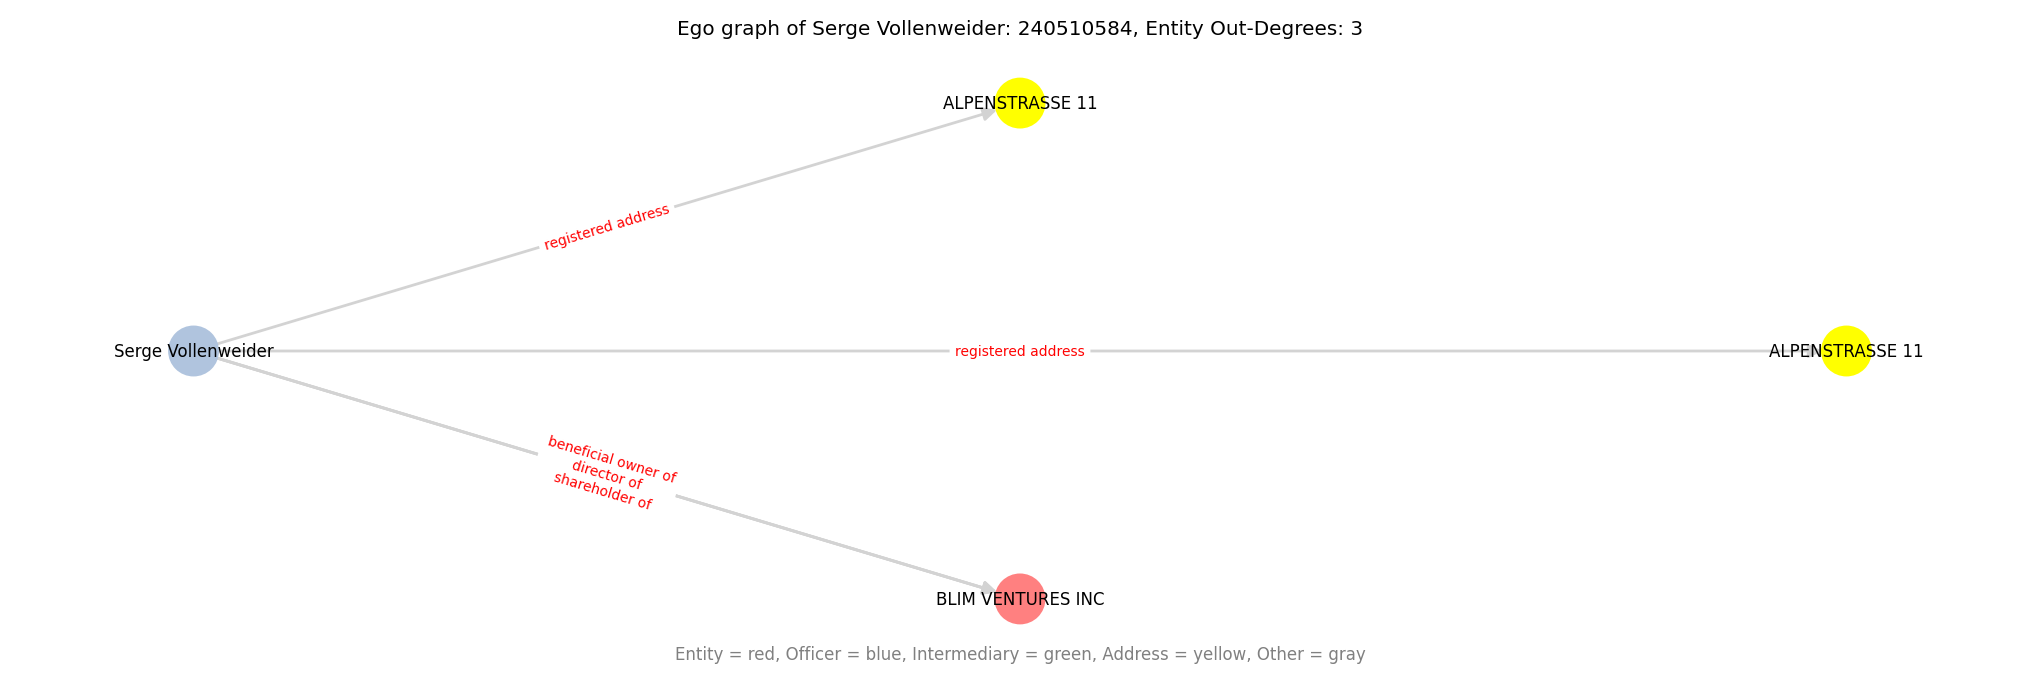

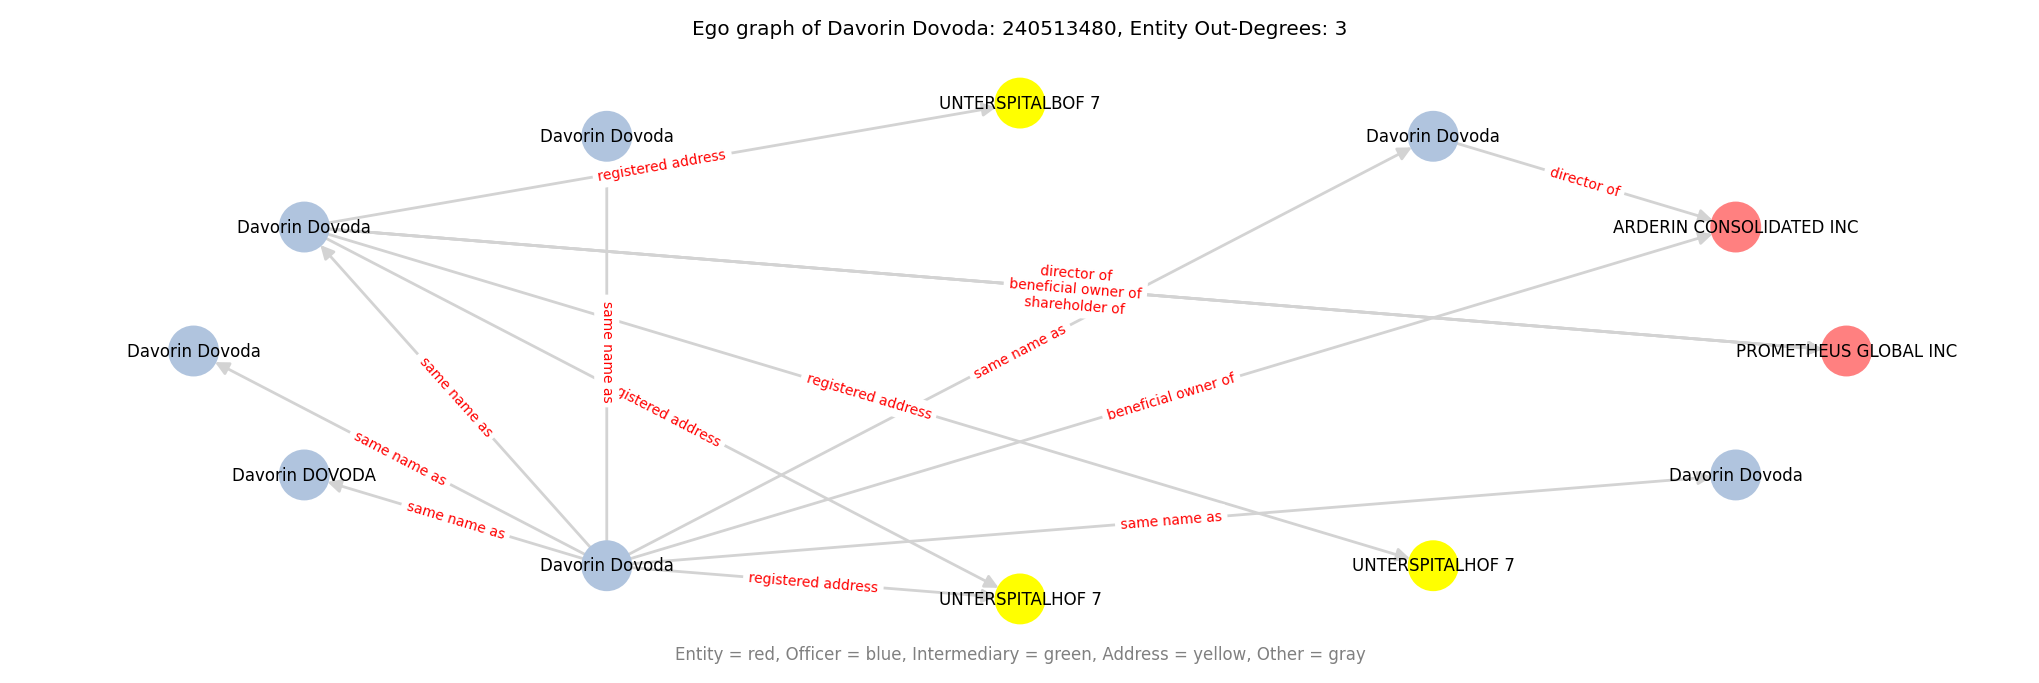

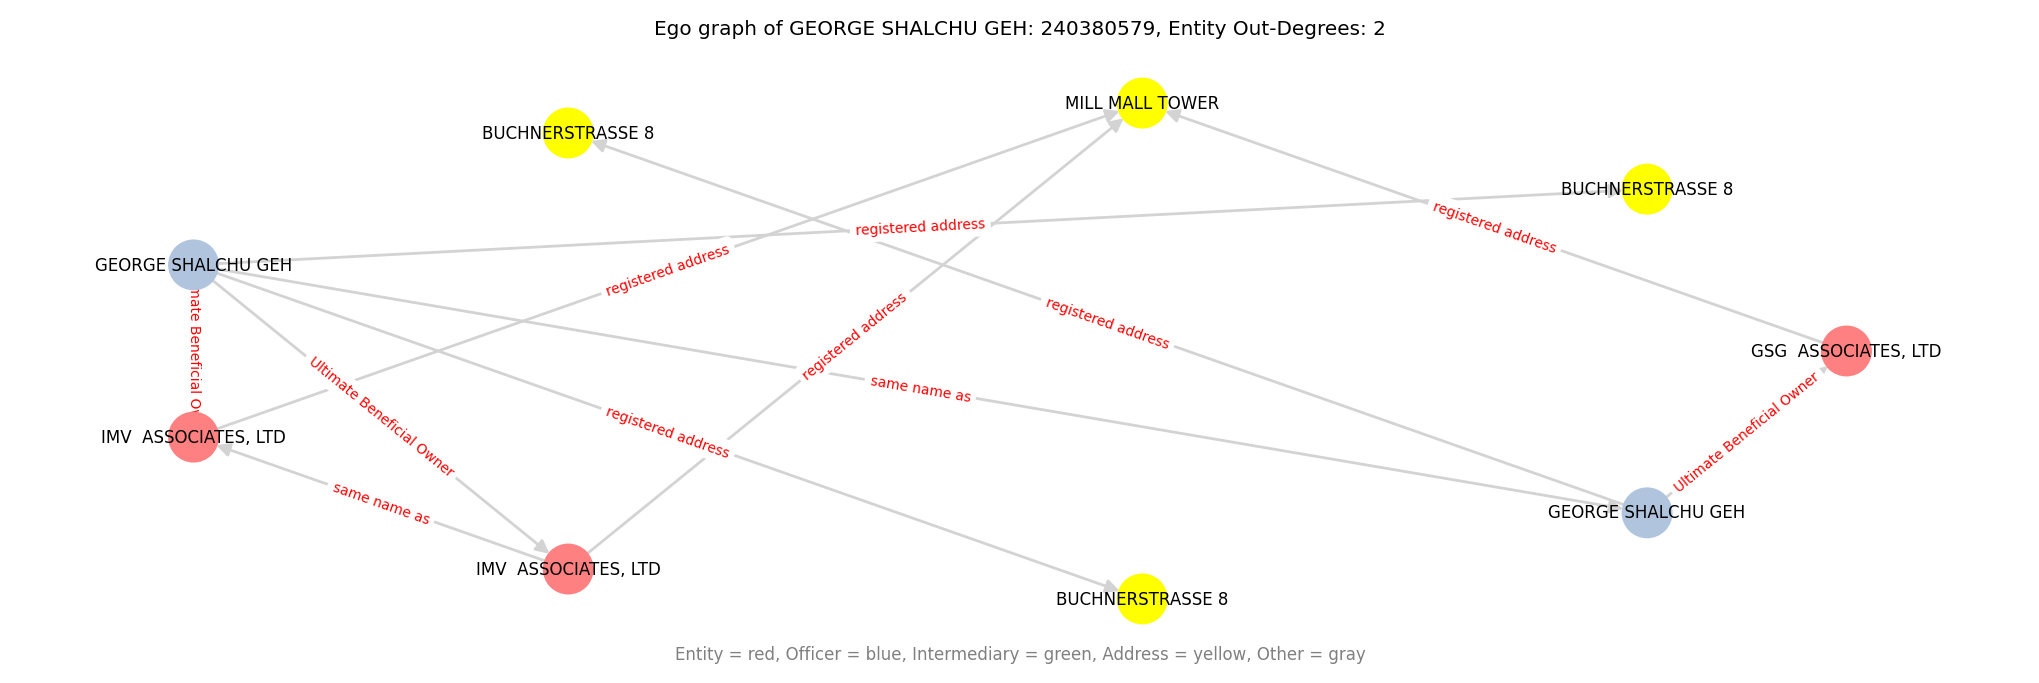

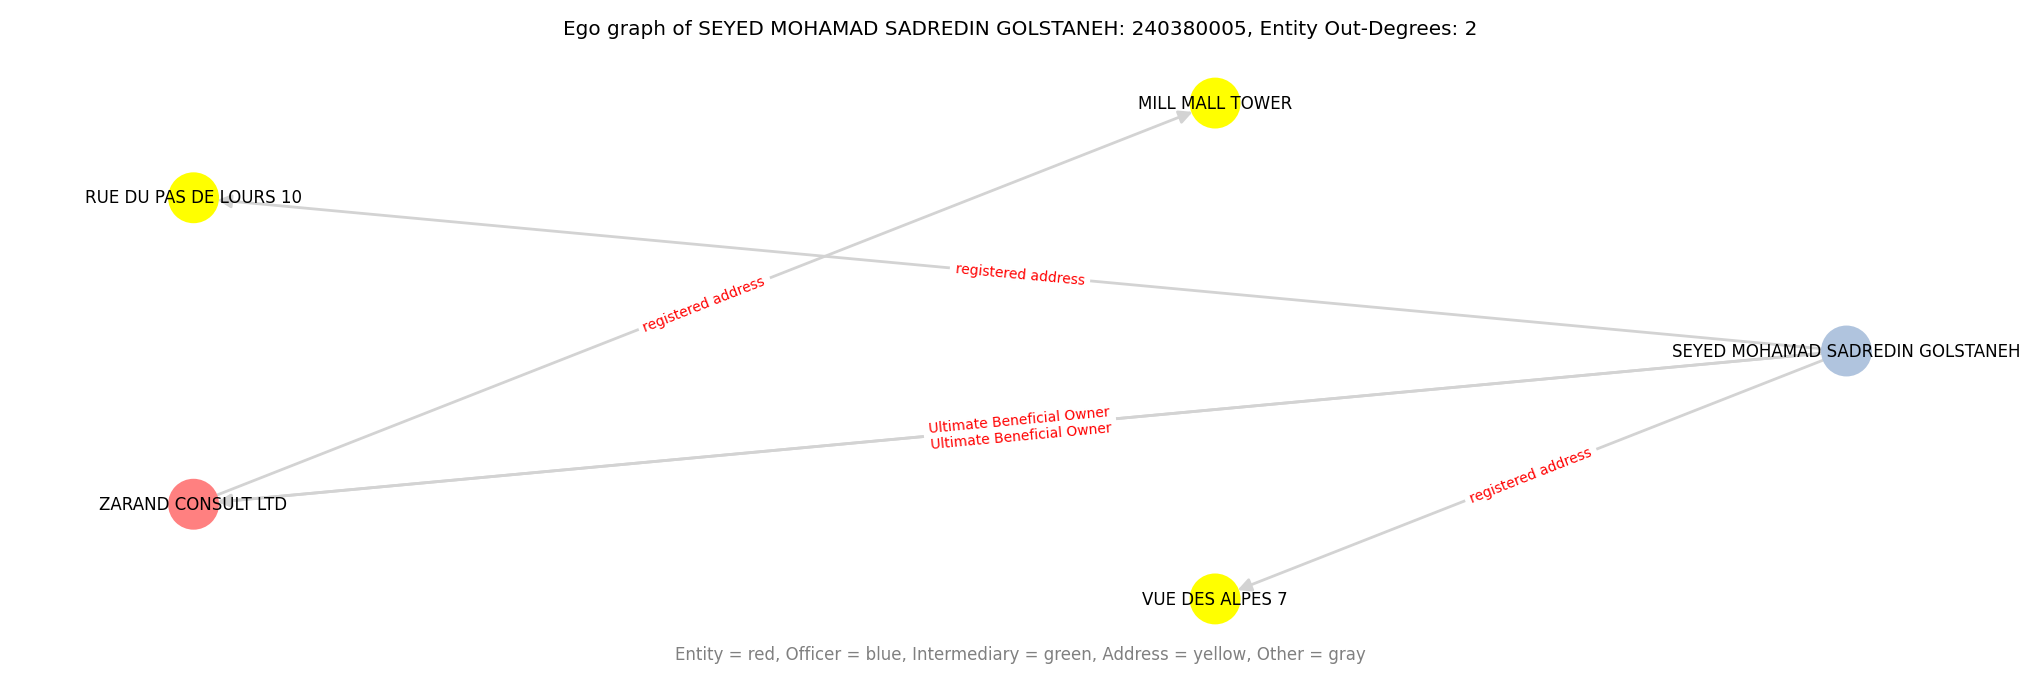

In [6]:
# Use the modified plotting function
for node, deg in list(degree.items())[:5]:
    plot_ego_with_labels(
        G, swiss_officers_entities_subgraph, node, color_map, plot_subgraph=False, ego_radius=2
    )

Das Problem scheint gross zu sein.